In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss)
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    # original_loss = focal_loss(student_outputs[:,0,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0520/weights_KD_segformer_0520_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.1
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.6534

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 515ms/step - loss: 0.5547
Average validation loss: 0.6590861082077026
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 529ms/step - loss: 0.5547 - val_loss: 0.6591
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 511ms/step - loss: 0.4218 - val_loss: 0.6591
Average validation loss: 0.6201608180999756
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 525ms/step - loss: 0.4218 - val_loss: 0.6396
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 525ms/step - loss: 0.3360 - val_loss: 0.6396
Average validation loss: 0.5064604878425598
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 537ms/step - loss: 0.3360 - val_loss: 0.5952
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segfo

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 962ms/step - loss: 0.0594
Average validation loss: 0.2788325622677803
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 974ms/step - loss: 0.0594 - val_loss: 0.2788
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 931ms/step - loss: 0.0534 - val_loss: 0.2788
Average validation loss: 0.12492707744240761
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 945ms/step - loss: 0.0534 - val_loss: 0.2019
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_10.pth'.
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 825ms/step - loss: 0.0514 - val_loss: 0.2019
Average validation loss: 0.1784248650074005
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 837ms/step - loss: 0.0514 - val_loss: 0.1941
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 29s 820ms/step - loss: 0.0500 - val_loss: 0.1941
Average validation loss

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 889ms/step - loss: 0.0316
Average validation loss: 0.0699410190184911
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 900ms/step - loss: 0.0316 - val_loss: 0.0699
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 832ms/step - loss: 0.0273 - val_loss: 0.0699
Average validation loss: 0.06257520367701848
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 844ms/step - loss: 0.0273 - val_loss: 0.0663
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_15.pth'.
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 31s 872ms/step - loss: 0.0243 - val_loss: 0.0663
Average validation loss: 0.035368717896441616
12/12 ━━━━━━━━━━━━━━━━━━━━ 32s 885ms/step - loss: 0.0243 - val_loss: 0.0560
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segforme

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 902ms/step - loss: 0.0112
Average validation loss: 0.022260502795688808
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 914ms/step - loss: 0.0112 - val_loss: 0.0223
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 796ms/step - loss: 0.0099 - val_loss: 0.0223
Average validation loss: 0.23281971644610167
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 807ms/step - loss: 0.0099 - val_loss: 0.1275
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 797ms/step - loss: 0.0093 - val_loss: 0.1275
Average validation loss: 0.026259256759658456
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 809ms/step - loss: 0.0093 - val_loss: 0.0938
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 54s 819ms/step - loss: 0.0089 - val_loss: 0.0938
Average validation loss: 0.009389689308591187
16/16 ━━━━━━━━━━━━━━━━━━━━ 54s 830ms/step - loss: 0.0089 - val_loss: 0.0727
Saved model weights to 'c:\天_11157065\

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 831ms/step - loss: 0.0197
Average validation loss: 0.1301042079925537
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 843ms/step - loss: 0.0197 - val_loss: 0.1301
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 815ms/step - loss: 0.0133 - val_loss: 0.1301
Average validation loss: 0.0069874491775408385
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 826ms/step - loss: 0.0133 - val_loss: 0.0685
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_25.pth'.
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 789ms/step - loss: 0.0112 - val_loss: 0.0685
Average validation loss: 0.004926823452115059
20/20 ━━━━━━━━━━━━━━━━━━━━ 50s 802ms/step - loss: 0.0112 - val_loss: 0.0473
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segfor

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 796ms/step - loss: 0.0159
Average validation loss: 0.029187914915382862
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 808ms/step - loss: 0.0159 - val_loss: 0.0292
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 840ms/step - loss: 0.0129 - val_loss: 0.0292
Average validation loss: 0.008583846657226482
24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 852ms/step - loss: 0.0129 - val_loss: 0.0189
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_30.pth'.
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 59s 804ms/step - loss: 0.0109 - val_loss: 0.0189
Average validation loss: 0.01698414081086715
24/24 ━━━━━━━━━━━━━━━━━━━━ 59s 816ms/step - loss: 0.0109 - val_loss: 0.0183
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 79s 801ms/step - loss: 0.0096 - val_loss: 0.0183
Ave

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 804ms/step - loss: 0.0155
Average validation loss: 0.08434045687317848
40/40 ━━━━━━━━━━━━━━━━━━━━ 33s 818ms/step - loss: 0.0155 - val_loss: 0.0843
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 67s 859ms/step - loss: 0.0117 - val_loss: 0.0843
Average validation loss: 0.049041788652539255
40/40 ━━━━━━━━━━━━━━━━━━━━ 68s 873ms/step - loss: 0.0117 - val_loss: 0.0667
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_50.pth'.
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 99s 792ms/step - loss: 0.0097 - val_loss: 0.0667
Average validation loss: 0.010120763775194063
40/40 ━━━━━━━━━━━━━━━━━━━━ 100s 806ms/step - loss: 0.0097 - val_loss: 0.0478
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segfo

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 38s 784ms/step - loss: 0.0088
Average validation loss: 0.009327280354530862
48/48 ━━━━━━━━━━━━━━━━━━━━ 38s 796ms/step - loss: 0.0088 - val_loss: 0.0093
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 78s 825ms/step - loss: 0.0069 - val_loss: 0.0093
Average validation loss: 0.06273721827892587
48/48 ━━━━━━━━━━━━━━━━━━━━ 78s 839ms/step - loss: 0.0069 - val_loss: 0.0360
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 118s 822ms/step - loss: 0.0059 - val_loss: 0.0360
Average validation loss: 0.005420645044068806
48/48 ━━━━━━━━━━━━━━━━━━━━ 119s 836ms/step - loss: 0.0059 - val_loss: 0.0258
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_60.pth'.
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 158s 808ms/step - loss: 0.0054 - val_loss: 0.0258


c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 46s 813ms/step - loss: 0.0069
Average validation loss: 0.005624325413789068
56/56 ━━━━━━━━━━━━━━━━━━━━ 46s 827ms/step - loss: 0.0069 - val_loss: 0.0056
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 91s 799ms/step - loss: 0.0054 - val_loss: 0.0056
Average validation loss: 0.00407812642099868
56/56 ━━━━━━━━━━━━━━━━━━━━ 92s 812ms/step - loss: 0.0054 - val_loss: 0.0049
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_70.pth'.
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 136s 795ms/step - loss: 0.0046 - val_loss: 0.0049
Average validation loss: 0.00409576715901494
56/56 ━━━━━━━━━━━━━━━━━━━━ 137s 809ms/step - loss: 0.0046 - val_loss: 0.0046
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 182s 798ms/step - loss: 0.0043 - val_loss: 0.0046
A

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 51s 800ms/step - loss: 0.0059
Average validation loss: 0.007575185016321484
64/64 ━━━━━━━━━━━━━━━━━━━━ 52s 813ms/step - loss: 0.0059 - val_loss: 0.0076
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 103s 802ms/step - loss: 0.0048 - val_loss: 0.0076
Average validation loss: 0.06299069745000452
64/64 ━━━━━━━━━━━━━━━━━━━━ 104s 815ms/step - loss: 0.0048 - val_loss: 0.0353
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 156s 809ms/step - loss: 0.0042 - val_loss: 0.0353
Average validation loss: 0.007108546924428083
64/64 ━━━━━━━━━━━━━━━━━━━━ 157s 822ms/step - loss: 0.0042 - val_loss: 0.0259
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_80.pth'.
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 208s 803ms/step - loss: 0.0039 - val_loss: 0.025

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 57s 792ms/step - loss: 0.0044
Average validation loss: 0.03256040387269524
72/72 ━━━━━━━━━━━━━━━━━━━━ 58s 805ms/step - loss: 0.0044 - val_loss: 0.0326
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 119s 850ms/step - loss: 0.0035 - val_loss: 0.0326
Average validation loss: 0.010611054920850115
72/72 ━━━━━━━━━━━━━━━━━━━━ 120s 863ms/step - loss: 0.0035 - val_loss: 0.0216
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_90.pth'.
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 178s 803ms/step - loss: 0.0031 - val_loss: 0.0216
Average validation loss: 0.013320352610511085
72/72 ━━━━━━━━━━━━━━━━━━━━ 179s 816ms/step - loss: 0.0031 - val_loss: 0.0188
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 243s 891ms/step - loss: 0.0030 - val_loss: 0.018

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 65s 812ms/step - loss: 0.0047
Average validation loss: 0.024074581253807993
80/80 ━━━━━━━━━━━━━━━━━━━━ 66s 826ms/step - loss: 0.0047 - val_loss: 0.0241
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 130s 796ms/step - loss: 0.0037 - val_loss: 0.0241
Average validation loss: 0.0030162129347445442
80/80 ━━━━━━━━━━━━━━━━━━━━ 131s 809ms/step - loss: 0.0037 - val_loss: 0.0135
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_100.pth'.
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 194s 793ms/step - loss: 0.0032 - val_loss: 0.0135
Average validation loss: 0.12261854829266668
80/80 ━━━━━━━━━━━━━━━━━━━━ 195s 807ms/step - loss: 0.0032 - val_loss: 0.0499
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 259s 796ms/step - loss: 0.0029 - val_loss: 0.

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 78s 812ms/step - loss: 0.0052
Average validation loss: 0.008210471719697429
96/96 ━━━━━━━━━━━━━━━━━━━━ 79s 826ms/step - loss: 0.0052 - val_loss: 0.0082
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 155s 790ms/step - loss: 0.0041 - val_loss: 0.0082
Average validation loss: 0.0070020708032340435
96/96 ━━━━━━━━━━━━━━━━━━━━ 156s 804ms/step - loss: 0.0041 - val_loss: 0.0076
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_120.pth'.
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 233s 794ms/step - loss: 0.0038 - val_loss: 0.0076
Average validation loss: 0.01187674751660476
96/96 ━━━━━━━━━━━━━━━━━━━━ 234s 808ms/step - loss: 0.0038 - val_loss: 0.0090
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 310s 795ms/step - loss: 0.0035 - val_loss: 0.

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 95s 795ms/step - loss: 0.0080
Average validation loss: 0.024936187888185184
120/120 ━━━━━━━━━━━━━━━━━━━━ 97s 808ms/step - loss: 0.0080 - val_loss: 0.0249
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 193s 798ms/step - loss: 0.0061 - val_loss: 0.0249
Average validation loss: 0.022666759261240562
120/120 ━━━━━━━━━━━━━━━━━━━━ 194s 811ms/step - loss: 0.0061 - val_loss: 0.0238
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_150.pth'.
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 290s 794ms/step - loss: 0.0054 - val_loss: 0.0238
Average validation loss: 0.006830751815383943
120/120 ━━━━━━━━━━━━━━━━━━━━ 291s 807ms/step - loss: 0.0054 - val_loss: 0.0181
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weight

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 115s 798ms/step - loss: 0.0065
Average validation loss: 0.00626338759644164
144/144 ━━━━━━━━━━━━━━━━━━━━ 117s 811ms/step - loss: 0.0065 - val_loss: 0.0063
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 231s 795ms/step - loss: 0.0053 - val_loss: 0.0063
Average validation loss: 0.004980394641784692
144/144 ━━━━━━━━━━━━━━━━━━━━ 233s 807ms/step - loss: 0.0053 - val_loss: 0.0056
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_180.pth'.
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 348s 795ms/step - loss: 0.0046 - val_loss: 0.0056
Average validation loss: 0.005217099681127972
144/144 ━━━━━━━━━━━━━━━━━━━━ 350s 808ms/step - loss: 0.0046 - val_loss: 0.0055
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 465s 801ms/step - loss: 0.0042

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 147s 922ms/step - loss: 0.0043
Average validation loss: 0.005242596261086874
160/160 ━━━━━━━━━━━━━━━━━━━━ 150s 935ms/step - loss: 0.0043 - val_loss: 0.0052
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 276s 792ms/step - loss: 0.0037 - val_loss: 0.0052
Average validation loss: 0.0037943833987810647
160/160 ━━━━━━━━━━━━━━━━━━━━ 278s 805ms/step - loss: 0.0037 - val_loss: 0.0045
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_200.pth'.
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 406s 794ms/step - loss: 0.0031 - val_loss: 0.0045
Average validation loss: 0.01892157165275421
160/160 ━━━━━━━━━━━━━━━━━━━━ 408s 807ms/step - loss: 0.0031 - val_loss: 0.0093
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 536s 799ms/step - loss: 0.002

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 159s 795ms/step - loss: 0.0050
Average validation loss: 0.016926728998032558
200/200 ━━━━━━━━━━━━━━━━━━━━ 162s 808ms/step - loss: 0.0050 - val_loss: 0.0169
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 321s 799ms/step - loss: 0.0040 - val_loss: 0.0169
Average validation loss: 0.003945154618122615
200/200 ━━━━━━━━━━━━━━━━━━━━ 324s 812ms/step - loss: 0.0040 - val_loss: 0.0104
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_250.pth'.
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 495s 855ms/step - loss: 0.0034 - val_loss: 0.0104
Average validation loss: 0.004690996097911011
200/200 ━━━━━━━━━━━━━━━━━━━━ 498s 868ms/step - loss: 0.0034 - val_loss: 0.0085
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 657s 796ms/step - loss: 0.003

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 191s 798ms/step - loss: 0.0038
Average validation loss: 0.005117725380402286
240/240 ━━━━━━━━━━━━━━━━━━━━ 195s 811ms/step - loss: 0.0038 - val_loss: 0.0051
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 388s 806ms/step - loss: 0.0031 - val_loss: 0.0051
Average validation loss: 0.0036868891372553963
240/240 ━━━━━━━━━━━━━━━━━━━━ 391s 819ms/step - loss: 0.0031 - val_loss: 0.0044
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_300.pth'.
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 585s 808ms/step - loss: 0.0027 - val_loss: 0.0044
Average validation loss: 0.0044361354983867805
240/240 ━━━━━━━━━━━━━━━━━━━━ 588s 821ms/step - loss: 0.0027 - val_loss: 0.0044
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 781s 803ms/step - loss: 0.0

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.2771628210693598, 0.1382268499303609, 0.032827230404752, 0.02090021587559022, 0.03404293178638909, 0.021352818804977382, 0.02198566581890918, 0.01449921135395319, 0.017647355351135565, 0.017482038904454385, 0.017406846298399614, 0.014976340096836795, 0.011839127408238708, 0.010710737521760168, 0.008724974982868686, 0.006722320656822354, 0.015252699451952179, 0.008536681334370048]
std_val_losses =  [0.19015120943327607, 0.11761216807009217, 0.025215299601598205, 0.03454711753965209, 0.08236542886062745, 0.04401602829066474, 0.039426961686768826, 0.022140205944138538, 0.03267906613160603, 0.03172019668446932, 0.02997588614981414, 0.03790050988010717, 0.023430500245127255, 0.017186195010135793, 0.010544200459430659, 0.010366768970402328, 0.02358885560749598, 0.014980113927603357]


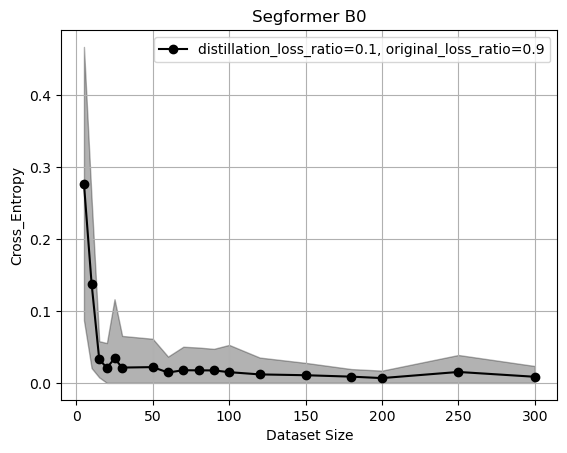

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0520')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0520_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0520_{int(teacher_ratio*100)}.png"))

plt.show()